# Variability of off-ball runs

This analysis is concerned with coming up with creative metrics to measure the variability of off-ball runs ending in the final third of the pitch during the respective player's own team's possessions. It utilises partial tracking data fron the UEFA Champions League 2022/2023 Final match between Manchester City and Inter.

What is meant by partial in this case is the fact that the provided dataset only contains a subset of all frames (i.e., the sampling rate is significantly lower than 25 fps) and the off-ball runs themselves were annotated. Having said this, only the latter are actually utilised.

![Off-ball run variability.](off-ball-run-variability.png "Off-ball run variability.")
<img src="off-ball-runs.png" alt="Off-ball runs, ending in the final third, during a player's own team possessions." height="3072"/>

As it can be seen from the plots and the metric scores as well, Foden's runs have been characterised with a significantly high degree of variability. Despite starting on the bench, he was able to cause troubles to Inter's defence, thanks to his technical skills and versatility. Particularly, the latter is relevant to his off-ball runs, which were interspersed with those of Bernardo Silva, both
of them performing runs which were cutting from the right towards the centre. There were a few runs from the centre of the field towards the right &mdash; I would imagine that those could have been part of a set-piece play.

On the other hand, John Stones' off-ball runs were characterised as most consistent. A versatile player himself as well, he took on the defensive midfielder role in this match and was involved with runs predominantly in the right-centre part of the field, collaborating with Bernardo Silva and Kevin de Bruyne.

Please, note that players with less than 5 in-possession runs ending in the final third have been excluded from metric calculation, in order to avoid unrealistically and unreliably skewed values.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import (
    circvar,
    kstest,
    linregress,
    median_abs_deviation,
    normaltest,
    shapiro,
)
from sklearn.metrics import make_scorer, root_mean_squared_error, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.random_projection import GaussianRandomProjection 
from sklearn_extra.cluster import KMedoids
from tqdm import tqdm


home_team = "Manchester City"
away_team = "Inter"
team_map = {
    'home_team': home_team,
    'away_team': away_team,
}

In [2]:
df_runs = pd.read_parquet(f"https://github.com/twelvefootball/twelve-respovision-CL-final/raw/refs/heads/main/Data/18768058_runs.parquet")
df_runs[['start_x', 'start_y', 'end_x', 'end_y']].describe()

,start_x,start_y,end_x,end_y
count,805.000000,805.000000,805.000000,805.000000
mean,49.480691,49.160281,49.560563,49.252051
std,18.277529,24.124698,24.534041,25.715977
min,3.168120,0.000000,0.117792,0.000000
25%,35.568098,30.956121,27.447889,28.752976
50%,49.721851,49.157933,49.646145,48.529549
75%,62.407124,68.727006,70.107990,69.551210
max,98.691084,99.352988,99.567317,100.000000


We note that the original data &mdash; in terms of pitch dimensions &mdash; is normalised to the $0, \ldots, 100$ range.

In [3]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

def transform_x_coordinates(x):
    return x * (PITCH_LENGTH / 100)

def transform_y_coordinates(y):
    return y * (PITCH_WIDTH / 100)

# Keep the normalised values for plotting purposes.
df_runs['start_x_normalised'] = df_runs.start_x
df_runs['start_y_normalised'] = df_runs.start_y
df_runs['end_x_normalised'] = df_runs.end_x
df_runs['end_y_normalised'] = df_runs.end_y

# Transform to standard pitch dimensions.
df_runs['start_x'] = df_runs.start_x.apply(transform_x_coordinates)
df_runs['start_y'] = df_runs.start_y.apply(transform_y_coordinates)
df_runs['end_x'] = df_runs.end_x.apply(transform_x_coordinates)
df_runs['end_y'] = df_runs.end_y.apply(transform_y_coordinates)

df_runs[['start_x', 'start_y', 'end_x', 'end_y']].describe()

,start_x,start_y,end_x,end_y
count,805.000000,805.000000,805.000000,805.000000
mean,51.954725,33.428991,52.038591,33.491395
std,19.191406,16.404794,25.760743,17.486864
min,3.326526,0.000000,0.123682,0.000000
25%,37.346503,21.050162,28.820283,19.552024
50%,52.207943,33.427395,52.128452,33.000093
75%,65.527480,46.734364,73.613390,47.294823
max,103.625639,67.560032,104.545683,68.000000


In [6]:
# We are interested only in the final-third runs which occur during a team's possession.

runs_f3 = df_runs[
    (df_runs.end_x >= PITCH_LENGTH * 2/3) &
    (df_runs['In possession runs'])
]
runs_f3['team'] = runs_f3.team.apply(team_map.get)
print(f"Runs shape: {runs_f3.shape}")
print(f"Columns: {df_runs.columns}")
assert runs_f3.shape[0] == 136

Runs shape: (136, 32)
Columns: Index(['player_id', 'jersey', 'team', 'frame_start', 'frame_end', 'start_x',
       'start_y', 'end_x', 'end_y', 'max_speed', 'avg_speed', 'player',
       'period', 'time_start', 'time_end', 'team_name', 'attacking_right',
       'wy_player_id', 'team_id', 'approx_time_start', 'approx_time_end',
       'Forward runs', 'Distance', 'Runs into box', 'xGRun',
       'In possession runs', 'possession_id', 'Target', 'start_x_normalised',
       'start_y_normalised', 'end_x_normalised', 'end_y_normalised'],
      dtype='object')


/tmp/ipykernel_70562/2854395030.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_f3['team'] = runs_f3.team.apply(team_map.get)


In [7]:
runs_f3[['start_x', 'start_y', 'end_x', 'end_y']].describe()

,start_x,start_y,end_x,end_y
count,136.000000,136.000000,136.000000,136.000000
mean,66.973072,34.151237,84.086414,34.106757
std,13.808779,18.469049,8.866992,17.001850
min,21.287012,0.000000,70.090317,0.890033
25%,60.762781,19.998927,76.975838,21.014476
50%,67.399949,34.649953,83.605993,36.216220
75%,75.018688,50.306437,89.927104,46.333137
max,101.062068,67.560032,104.545683,67.789365


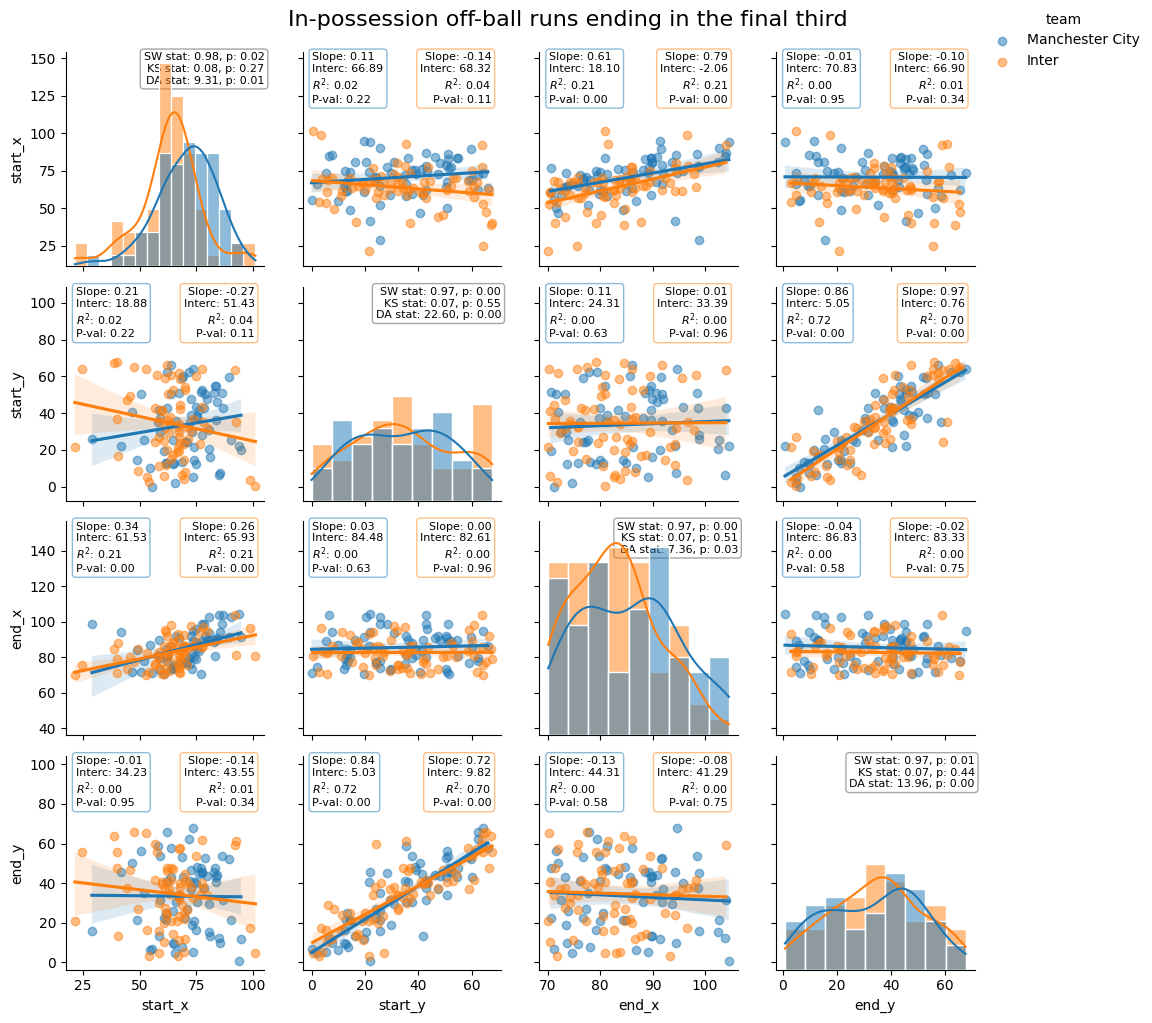

In [65]:
def geometric_median(X, tol=1e-5):
    """
    Finds the geometric median of a set of points in multi-dimensional space.
    
    Parameters:
    - X: np.ndarray, shape (n_samples, n_features)
    - tol: tolerance level for stopping the iterative process
    
    Returns:
    - np.ndarray of the geometric median
    """
    def objective_function(y):
        return np.sum(np.sqrt(np.sum((X - y)**2, axis=1)))
    
    # Initial guess: the mean of the points
    initial_guess = np.mean(X, axis=0)
    result = minimize(objective_function, initial_guess, tol=tol)
    
    return result.x

def cdist_gm(X, tol=1e-5):
    """
    Compute Euclidean distances to the geometric median.
    """
    gm = geometric_median(X, tol)
    return cdist(X, [gm], metric='euclidean').flatten()

def multivariate_madgm(X, tol=1e-5):
    """
    Computes the Multivariate Median Absolute Deviation (MADGM).
    
    Parameters:
    - X: np.ndarray, shape (n_samples, n_features)
    - tol: tolerance level for finding the geometric median
    
    Returns:
    - float, the MADGM value
    """
    distances = cdist_gm(X, tol)
    madgm = np.median(distances)
    return madgm

def normality_tests(data_column):
    """
    Perform normality tests using the following methods:
    - Shapiro-Wilk: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
    - Kolmogorov-Smirnov: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstat.html
    - D'Agostino and Pearson's: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    """
    shapiro_res = shapiro(data_column)
    ks_res = kstest(data_column, 'norm', args=(np.mean(data_column), np.std(data_column)))
    dagostino_res = normaltest(data_column)

    result_str = (f"SW stat: {shapiro_res.statistic:.2f}, p: {shapiro_res.pvalue:.2f}\n"
                  f"KS stat: {ks_res.statistic:.2f}, p: {ks_res.pvalue:.2f}\n"
                  f"DA stat: {dagostino_res.statistic:.2f}, p: {dagostino_res.pvalue:.2f}")
    return result_str

def regplot_with_stats(x, y, **kwargs):
    """
    Add regression statistics to off-diagonal plots.
    """
    sns.regplot(x=x, y=y, **kwargs, scatter_kws={'alpha': 0.5})
    
    slope, intercept, r_value, p_value, _ = linregress(x, y)
    annotation = (f"Slope: {slope:.2f}\n"
                  f"Interc: {intercept:.2f}\n"
                  f"$R^2$: {r_value**2:.2f}\n"
                  f"P-val: {p_value:.2f}")

    if kwargs['label'] == "Manchester City":
        xy = 0.05, 1.0
        ha = 'left'
    elif kwargs['label'] == "Inter":
        xy = 0.95, 1.0
        ha = 'right'
    else:
        raise ValueError(f"Invalid label: {kwargs['label']}")

    plt.gca().annotate(
        annotation, xy=xy, xycoords='axes fraction',
        ha=ha, va='top',
        fontsize=8,
        bbox=dict(
            boxstyle="round,pad=0.3",
            edgecolor=kwargs['color'],
            facecolor="white",
            alpha=0.5,
        ),
    )

# A Seaborn pair-grid with normality tests on diagonals and regression plots on off-diagonals.
g = sns.PairGrid(runs_f3, vars=['start_x', 'start_y', 'end_x', 'end_y'], hue='team')
g.map_diag(sns.histplot, kde=True, color=".3", edgecolor="w", stat="density", alpha=0.5)
g.map_offdiag(regplot_with_stats)

for i, var in enumerate(['start_x', 'start_y', 'end_x', 'end_y']):
    ax = g.axes[i, i]
    test_results = normality_tests(runs_f3[var])
    ax.annotate(
        test_results, xy=(1.0, 1.0), xycoords='axes fraction', 
        ha='right', va='top',
        fontsize=8,
        bbox=dict(
            boxstyle="round,pad=0.3", 
            edgecolor="gray",
            facecolor="white",
            alpha=0.7,
        ),
    )

y_margin = 0.1
for ax in g.axes.flat:
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - y_margin * abs(y_min), y_max + y_margin * abs(y_max))

g.add_legend(loc='upper right')
plt.suptitle("In-possession off-ball runs ending in the final third", y=1.02, fontsize=16)
plt.show()
g.savefig('runs_f3_pair_grid.png')

### Normality tests

- _SW stat_: [Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) test for normality. Tests the null hypothesis that the data was drawn from a normal distribution.
- _KS stat_: One-sample [Kolmogorov-Smirnov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstat.html) test for goodness of fit. The null hypothesis is that the CDFs of the provided distribution and the reference distributions (i.e., the Gaussian distribution) are identical.
- _DA stat_: Test the null hypothesis that a sample comes from a normal distribution. It is based on [D'Agostino and Pearson's test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) that combines skew and kurtosis to produce an omnibus test of normality.

#### Observations

When examining the one-dimensional components of the runs &mdash; namely the starting $x$ and $y$ and ending $x$ and $y$ coordinates &mdash; we can reject the null hypotheses based on the Shapiro-Wilk and D'Agostino and Pearson's tests, but cannot reject the null hypothesis based on the Kolmogorov-Smirnov test, when we specify explicitly the distribution parameters.

In order to be on the conservative side, this analysis won't draw any strong assumptions regarding the underlying distribution and that's why we'll favour median-based statistics in the following sections.

In [69]:
pitch = Pitch(
    pitch_type="opta",
    goal_type='box',
    pitch_color="w",
    linewidth=1,
    spot_scale=0,
    line_color="k",
    line_zorder=1,
)

def plot_run_arrow(pitch, ax, row, start_x, start_y, end_x, end_y):
    pitch.arrows(
        start_x, start_y,
        end_x, end_y,
        width=1,
        headwidth=3, headlength=3, headaxislength=2,
        color='green',
        edgecolor="gray" if row['Target'] else 'white', # Differentiate target and off-target runs.
        linewidth=1 if row['Target'] else 0, # Differentiate target and off-target runs.
        alpha=0.8,
        zorder=3,
        label=row['player'],
        ax=ax,
    )

def plot_run_avg_arrow(pitch, ax, row, start_x, start_y, end_x, end_y, color, zorder):
    pitch.arrows(
        start_x, start_y,
        end_x, end_y,
        width=2.2,
        headwidth=3, headlength=3, headaxislength=2,
        color=color,
        alpha=0.8,
        zorder=zorder,
        label=row['player'],
        ax=ax,
    )

def plot_player_subgrid(ax, player, postfix='', median_centred=False):
    player_runs = runs_f3[runs_f3.player == player][['start_x_normalised', 'start_y_normalised', 'end_x_normalised', 'end_y_normalised', 'Target', 'player', 'team_name']]

    pitch.draw(ax=ax)

    median_start_x, median_start_y = geometric_median(player_runs[['start_x_normalised', 'start_y_normalised']])
    median_end_x, median_end_y = geometric_median(player_runs[['end_x_normalised', 'end_y_normalised']])

    for _, row in player_runs.iterrows():
        if not median_centred:
            start_x = row['start_x_normalised']
            end_x = row['end_x_normalised']
            start_y = row['start_y_normalised']
            end_y = row['end_y_normalised']
            
        else:
            start_x = median_start_x
            end_x = median_start_x + row['end_x_normalised'] - row['start_x_normalised']
            start_y = median_start_y
            end_y = median_start_y + row['end_y_normalised'] - row['start_y_normalised']

        plot_run_arrow(pitch, ax, row, start_x, start_y, end_x, end_y)

    mean_start_x = player_runs['start_x_normalised'].mean()
    mean_start_y = player_runs['start_y_normalised'].mean()
    mean_end_x = player_runs['end_x_normalised'].mean()
    mean_end_y = player_runs['end_y_normalised'].mean()

    plot_run_avg_arrow(pitch, ax, row,  mean_start_x, mean_start_y, mean_end_x, mean_end_y, color='orange', zorder=4)
    plot_run_avg_arrow(pitch, ax, row, median_start_x, median_start_y, median_end_x, median_end_y, color='purple', zorder=5)

    ax.set_title(f'{player}{postfix}')

In [11]:
runs_f3.player_id.unique()

array(['home_team_player_10', 'home_team_player_17',
       'home_team_player_20', 'home_team_player_25', 'home_team_player_3',
       'home_team_player_47', 'home_team_player_5', 'home_team_player_8',
       'home_team_player_9', 'away_team_player_10', 'away_team_player_2',
       'away_team_player_20', 'away_team_player_23',
       'away_team_player_32', 'away_team_player_77', 'away_team_player_9',
       'away_team_player_95', 'away_team_player_12',
       'away_team_player_22', 'away_team_player_8', 'away_team_player_90'],
      dtype=object)

In [12]:
# Filter out the players with less than 5 in-possession runs, ending in the final third.

coord_cols = ['start_x', 'start_y', 'end_x', 'end_y']
num_runs_f3 = runs_f3[['player_id', 'jersey']].groupby('player_id').count().rename(columns={'jersey': 'num_runs'}).sort_values('num_runs', ascending=False)
player_runs_f3 = runs_f3[runs_f3.player_id.isin(num_runs_f3[num_runs_f3.num_runs >= 5].index)][['start_x', 'start_y', 'end_x', 'end_y', 'team', 'player']]
assert (player_runs_f3[['player', 'team']].groupby('player').count().rename(columns={'team': 'num_runs'}).sort_values('num_runs', ascending=False) >= 5).num_runs.all()
player_runs_f3

,start_x,start_y,end_x,end_y,team,player
1,82.690177,50.961024,88.464370,45.547495,Manchester City,Jack Grealish
6,63.644374,65.904431,86.146051,57.597383,Manchester City,Jack Grealish
9,62.211663,62.243625,77.925736,65.647059,Manchester City,Jack Grealish
13,76.888832,51.366247,70.530147,47.854392,Manchester City,Jack Grealish
15,83.661502,54.507108,89.776264,43.343824,Manchester City,Jack Grealish
...,...,...,...,...,...,...
796,76.482212,23.013400,94.345123,34.013651,Inter,Romelu Lukaku
797,69.524369,22.948363,85.616640,21.815281,Inter,Romelu Lukaku
798,63.294879,37.781199,86.601318,34.335805,Inter,Romelu Lukaku
803,67.463698,29.772083,89.514549,31.802270,Inter,Romelu Lukaku


### Mean absolute deviation of random-projection-transformed data ($rp\_mad$)

Transforms $1000$ copies of the dataset, via Gaussian Random Projection, to a single dimension and measure the median absolute deviation (_MAD_) of the resulting points.

The idea is to reduce the dimensionality and measure the variability based on that, without assuming anything
about the underlying distribution.

Please, note that Gaussian Random Projection doesn't assume anything about the underlying distribution, but the Gaussian part pertains to randomness sampling in terms of the transformations themselves.

In [13]:
# This has been added post-calculation, for the purpose of optionally skipping re-calculation, as necessary.
player_rp_mad_map_cache = {
    'Jack Grealish': 11.252056457701334,
    'Kevin De Bruyne': 12.915336739572947,
    'Bernardo Silva': 13.518952574768887,
    'Phil Foden': 13.970913416730532,
    'John Stones': 9.856337284884411,
    'İlkay Gündoğan': 10.954383757724687,
    'Erling Haaland': 11.238380458056158,
    'Lautaro Martínez': 8.440546441908777,
    'Denzel Dumfries': 12.635823454535359,
    'Hakan Çalhanoğlu': 15.79976833972259,
    'Nicolò Barella': 9.67461759758959,
    'Federico Dimarco': 10.21187932479695,
    'Edin Džeko': 11.937905492051714,
    'Robin Gosens': 10.127807310888533,
    'Romelu Lukaku': 9.039039443132094,
}

if player_rp_mad_map_cache:
    player_rp_mad_map = player_rp_mad_map_cache
else:
    player_rp_mad = pd.DataFrame.from_dict({player: {'rp_mad': 0.0} for player in player_runs_f3.player.unique()}, orient='index')
    n_rp_mad = 1000

    for _ in range(n_rp_mad):
        player_rp_mad_iter = pd.DataFrame(np.concatenate([
            player_runs_f3.player.values.reshape(-1, 1),
            GaussianRandomProjection(n_components=1).fit_transform(player_runs_f3[coord_cols]),
        ], axis=1)).rename(columns={0: 'player', 1: 'rp'}).groupby('player').agg(rp_mad=('rp', median_abs_deviation))
        player_rp_mad['rp_mad'] = player_rp_mad.rp_mad + player_rp_mad_iter.rp_mad

    player_rp_mad['rp_mad'] = player_rp_mad.rp_mad / n_rp_mad
    player_rp_mad_map = player_rp_mad.to_dict()['rp_mad']
    player_rp_mad

In [14]:
player_rp_mad_map

{'Jack Grealish': 11.252056457701334,
 'Kevin De Bruyne': 12.915336739572947,
 'Bernardo Silva': 13.518952574768887,
 'Phil Foden': 13.970913416730532,
 'John Stones': 9.856337284884411,
 'İlkay Gündoğan': 10.954383757724687,
 'Erling Haaland': 11.238380458056158,
 'Lautaro Martínez': 8.440546441908777,
 'Denzel Dumfries': 12.635823454535359,
 'Hakan Çalhanoğlu': 15.79976833972259,
 'Nicolò Barella': 9.67461759758959,
 'Federico Dimarco': 10.21187932479695,
 'Edin Džeko': 11.937905492051714,
 'Robin Gosens': 10.127807310888533,
 'Romelu Lukaku': 9.039039443132094}

### MLP RMSE ($mlp\_rmse$)

The dataset is augmented with 19 mutated copies of itself, to which random noise from $N(\mu = 0.0, \sigma = 0.35)$ is added.

In a cross-validation fashion, the dataset is trained on all players but one, and predictions are made on the remaining player. The inputs are the starting locations and the outputs are the ending locations. This metric captures the "difficulty" with which the model is able to predict the ending locations of a given player's runs, i.e., how dissimilar they are from other players' runs.

In [16]:
# This has been added post-calculation, for the purpose of optionally skipping re-calculation, as necessary.
mlp_scores_cache = dict([
    ('Romelu Lukaku', 8.411561302337478),
    ('İlkay Gündoğan', 8.980513968978258),
    ('Kevin De Bruyne', 15.119885309533275),
    ('John Stones', 20.740167466650995),
    ('Bernardo Silva', 45.53525068665645),
    ('Nicolò Barella', 48.65790776390415),
    ('Denzel Dumfries', 50.4326736126896),
    ('Lautaro Martínez', 51.38523875424399),
    ('Edin Džeko', 53.92793931031328),
    ('Phil Foden', 55.92316243085713),
    ('Erling Haaland', 58.04066603987893),
    ('Federico Dimarco', 62.89517517977559),
    ('Jack Grealish', 63.12027715648854),
    ('Robin Gosens', 63.24961079240147),
    ('Hakan Çalhanoğlu', 60.976611275477794),
])

if mlp_scores_cache:
    mlp_scores = mlp_scores_cache
else:
    n_mutated_copies = 19
    mlp_runs_f3 = pd.concat([
        runs_f3[['start_x', 'start_y', 'end_x', 'end_y', 'player']]
        for _ in range(n_mutated_copies)
    ], axis=0, ignore_index=True) 
    augmentation_offsets = np.random.normal(0, 0.35, ((n_mutated_copies - 1) * runs_f3.shape[0], len(coord_cols)))
    mlp_runs_f3.loc[runs_f3.shape[0]:, coord_cols] = mlp_runs_f3.loc[runs_f3.shape[0]:, coord_cols].values + augmentation_offsets

    param_grid = {
        'hidden_layer_sizes': [(i, 1) for i in range(4, 30)],
    }

    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    cv_params = dict(
        estimator=MLPRegressor(),
        param_grid=param_grid,
        n_jobs=1,
        verbose=True,
        cv=5,
        scoring=rmse_scorer,
    )

    cv_results = {}
    mlp_scores = {}
    for player in player_runs_f3.player.unique():
        cv_df = mlp_runs_f3[mlp_runs_f3.player != player][coord_cols]
        test_df = mlp_runs_f3[mlp_runs_f3.player == player][coord_cols]

        cv = GridSearchCV(**cv_params)
        cv.fit(cv_df[coord_cols[:2]].values, cv_df[coord_cols[2:]].values)

        pred = cv.predict(test_df[coord_cols[:2]].values)
        rmse_test = root_mean_squared_error(test_df[coord_cols[2:]].values, pred)
        
        cv_results[player] = cv.best_params_
        mlp_scores[player] = rmse_test
        cv = cv_df = test_df = None

In [17]:
mlp_scores

{'Romelu Lukaku': 8.411561302337478,
 'İlkay Gündoğan': 8.980513968978258,
 'Kevin De Bruyne': 15.119885309533275,
 'John Stones': 20.740167466650995,
 'Bernardo Silva': 45.53525068665645,
 'Nicolò Barella': 48.65790776390415,
 'Denzel Dumfries': 50.4326736126896,
 'Lautaro Martínez': 51.38523875424399,
 'Edin Džeko': 53.92793931031328,
 'Phil Foden': 55.92316243085713,
 'Erling Haaland': 58.04066603987893,
 'Federico Dimarco': 62.89517517977559,
 'Jack Grealish': 63.12027715648854,
 'Robin Gosens': 63.24961079240147,
 'Hakan Çalhanoğlu': 60.976611275477794}

### Proportion of misclustering ($nccp\_c5$ and $nccp\_c12$)

This works by clustering the data via the [$K$-medoids algorithm](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html) &mdash; and the best values for $k$, namely $5$ and $12$, are found via calculating the [Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of the resulting clustering. Then, the propotion of misclustering is calculated as the proportion of runs (on a per-player basis) which are outside the cluster where the largest number of the runs of the same player have been assigned.

The intuition for visually picking $5$ and $12$ is that they correspond to the largest values greater than $2$ and $3$, which themselves are too low for a total number of clusters of player runs; even $5$ isn't sufficiently large, but offers a reference point which groups runs in a bit broader clusters, whereas $12$ offers finer granularity.

100%|██████████| 28/28 [00:00<00:00, 178.26it/s]
/tmp/ipykernel_70562/3820545686.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_f3[f'clusters_{k}'] = clusters[k]


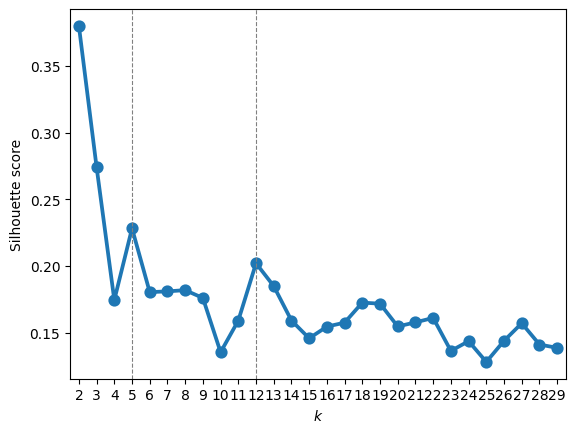

,Silhouette score
k,
2,0.379908
3,0.274040
4,0.174528
5,0.228246
6,0.180491
7,0.181054
8,0.181975
9,0.176103
10,0.135484


In [58]:
# These have been determined based on a visual inspection of the resulting Silhouette score plot.
best_ks = [5, 12]

clusters = {}
silhouette_scores = {}
for k in tqdm(range(2, 30)):
    clusters[k] = KMedoids(n_clusters=k).fit_predict(runs_f3[coord_cols].values)
    silhouette_scores[k] = silhouette_score(runs_f3[coord_cols].values, clusters[k])

def non_core_clusters_prop(cs):
    counts = Counter(cs).values()
    return 1 - max(counts) / sum(counts)

for k in best_ks:
    runs_f3[f'clusters_{k}'] = clusters[k]

non_core_clusters_prop_c = {
    k: runs_f3[['player', f'clusters_{k}']].groupby('player').agg(non_core_clusters_prop=(f'clusters_{k}', non_core_clusters_prop)).to_dict()['non_core_clusters_prop']
    for k in best_ks
}

silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index').reset_index().rename(columns={'index': 'k', 0: 'Silhouette score'})
ax = sns.pointplot(silhouette_df.rename(columns={'k': '$k$'}), x="$k$", y="Silhouette score")
for k in best_ks:
    ax.axvline(x=k-silhouette_df.k.min(), color='gray', linestyle='--', linewidth=0.8)
plt.show()

(silhouette_df.set_index('k').style
    .bar(color='#5fba7d', vmin=0.0, vmax=0.5) # Setting the maximum to 0.5 for visualisation purposes only. The actual value range is [-1.0;1.0].
    .apply(lambda col: [
        'font-weight:bold' if val in sorted(col, reverse=True)[2:4] else '' for val in col
    ]))

### Circular variance ($circvar$)

The [circular variance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circvar.html) of all run angles, relative to the horizontal line parallel to the $x$-axis, on which the starting location of the median vector lies. All other vectors are moved to the same starting location, and the metric is computed based on that. Please, note that this metric doesn't take into account run distances (i.e., vector magnitudes).

### Median of distances to the geometric median ($mmadgm$)
_MMADGM_ is a robust measure of the variability of a multivariate sample. Depends on computing the [geometric median](https://en.wikipedia.org/wiki/Geometric_median). Works in $4$ dimensions, namely starting and ending $x$ and $y$ coordinates.

### Incidental multivariate median of distances to the geometric median ($immadgm$)
Utilises the same method as above, but takes the median of the starting locations and the median of the ending locations separately, computes the corresponding _MMADGM_ values and adds them together.

In [66]:
player_stats = defaultdict(lambda: defaultdict(float))

for player in player_runs_f3.player.unique():
    dx = player_runs_f3[player_runs_f3.player == player].end_x - player_runs_f3[player_runs_f3.player == player].start_x
    dy = player_runs_f3[player_runs_f3.player == player].end_y - player_runs_f3[player_runs_f3.player == player].start_y
    cv = circvar(np.arctan2(dy, dx))
    player_stats[player]['circvar'] = cv

    mmadgm = multivariate_madgm(player_runs_f3[player_runs_f3.player == player][coord_cols])
    player_stats[player]['mmadgm'] = mmadgm

    # Incidental Multivariate MADGM.
    player_stats[player]['immadgm'] = (
        multivariate_madgm(player_runs_f3[player_runs_f3.player == player][coord_cols[:2]]) + 
        multivariate_madgm(player_runs_f3[player_runs_f3.player == player][coord_cols[2:]])
    )

    player_stats[player]['mlp_rmse_score'] = mlp_scores[player]

    player_stats[player]['rp_mad'] = player_rp_mad_map[player]

    for k in best_ks:
        player_stats[player][f'non_core_clusters_prop_c{k}'] = non_core_clusters_prop_c[k][player]

In [67]:
player_team_map = {
    k: team_map[v] for k, v in
    df_runs[['player', 'team']].set_index('player').to_dict()['team'].items()
}

player_stats_df = pd.DataFrame.from_dict(player_stats, orient='index')
metrics = list(player_stats.items())[0][1].keys()
for metric in metrics:
    player_stats_df[f'{metric}_rank'] = player_stats_df[metric].rank(method='max', ascending=False).astype(int)

player_stats_df['overall_rank'] = player_stats_df[[c for c in player_stats_df.columns if c.endswith('_rank')]].sum(axis=1).rank(method='min', ascending=True).astype(int)
player_stats_df.sort_values('overall_rank', inplace=True)
player_stats_df['team'] = list(map(player_team_map.get, player_stats_df.index))
(player_stats_df
    .style
    .format(precision=2)
    .set_caption('Off-ball-run variability')
    .background_gradient(cmap="Greens", subset=[c for c in player_stats_df.columns if not c.endswith('_rank') and c != 'team'])
    .background_gradient(cmap="Greens_r", subset=[c for c in player_stats_df.columns if c.endswith('_rank') and c != 'team'])
    .apply(lambda col: ['font-weight:bold' if val == col.max() and val not in team_map.values() else '' for val in col])
    .set_table_styles([
        dict(selector="th", props=[('max-width', '80px')]),
        dict(
            selector="th.col_heading",
            props=[
                ("writing-mode", "vertical-rl"), 
                ('transform', 'rotateZ(180deg)'),
                ('text-align', 'left'),
            ],
        )],
    ))

,circvar,mmadgm,immadgm,mlp_rmse_score,rp_mad,non_core_clusters_prop_c5,non_core_clusters_prop_c12,circvar_rank,mmadgm_rank,immadgm_rank,mlp_rmse_score_rank,rp_mad_rank,non_core_clusters_prop_c5_rank,non_core_clusters_prop_c12_rank,overall_rank,team
Phil Foden,0.16,18.88,27.69,55.92,13.97,0.62,0.77,4,2,2,6,2,1,3,1,Manchester City
Hakan Çalhanoğlu,0.20,16.43,24.73,60.98,15.80,0.60,0.80,3,5,4,4,1,2,2,2,Inter
Erling Haaland,0.11,15.41,23.67,58.04,11.24,0.50,0.80,7,8,5,5,8,8,2,3,Manchester City
Jack Grealish,0.33,14.79,22.31,63.12,11.25,0.45,0.64,2,12,8,2,7,9,4,4,Manchester City
Edin Džeko,0.09,19.36,24.98,53.93,11.94,0.50,0.50,9,1,3,7,6,8,10,4,Inter
Bernardo Silva,0.40,18.58,29.25,45.54,13.52,0.29,0.43,1,4,1,11,3,14,11,6,Manchester City
Denzel Dumfries,0.16,18.73,22.81,50.43,12.64,0.56,0.33,5,3,7,9,5,3,15,7,Inter
Kevin De Bruyne,0.11,16.32,23.46,15.12,12.92,0.33,0.50,8,6,6,13,4,12,10,8,Manchester City
İlkay Gündoğan,0.07,16.17,22.24,8.98,10.95,0.43,0.57,11,7,9,14,9,10,7,9,Manchester City
Robin Gosens,0.02,13.32,17.51,63.25,10.13,0.50,0.50,14,13,14,1,11,8,10,10,Inter


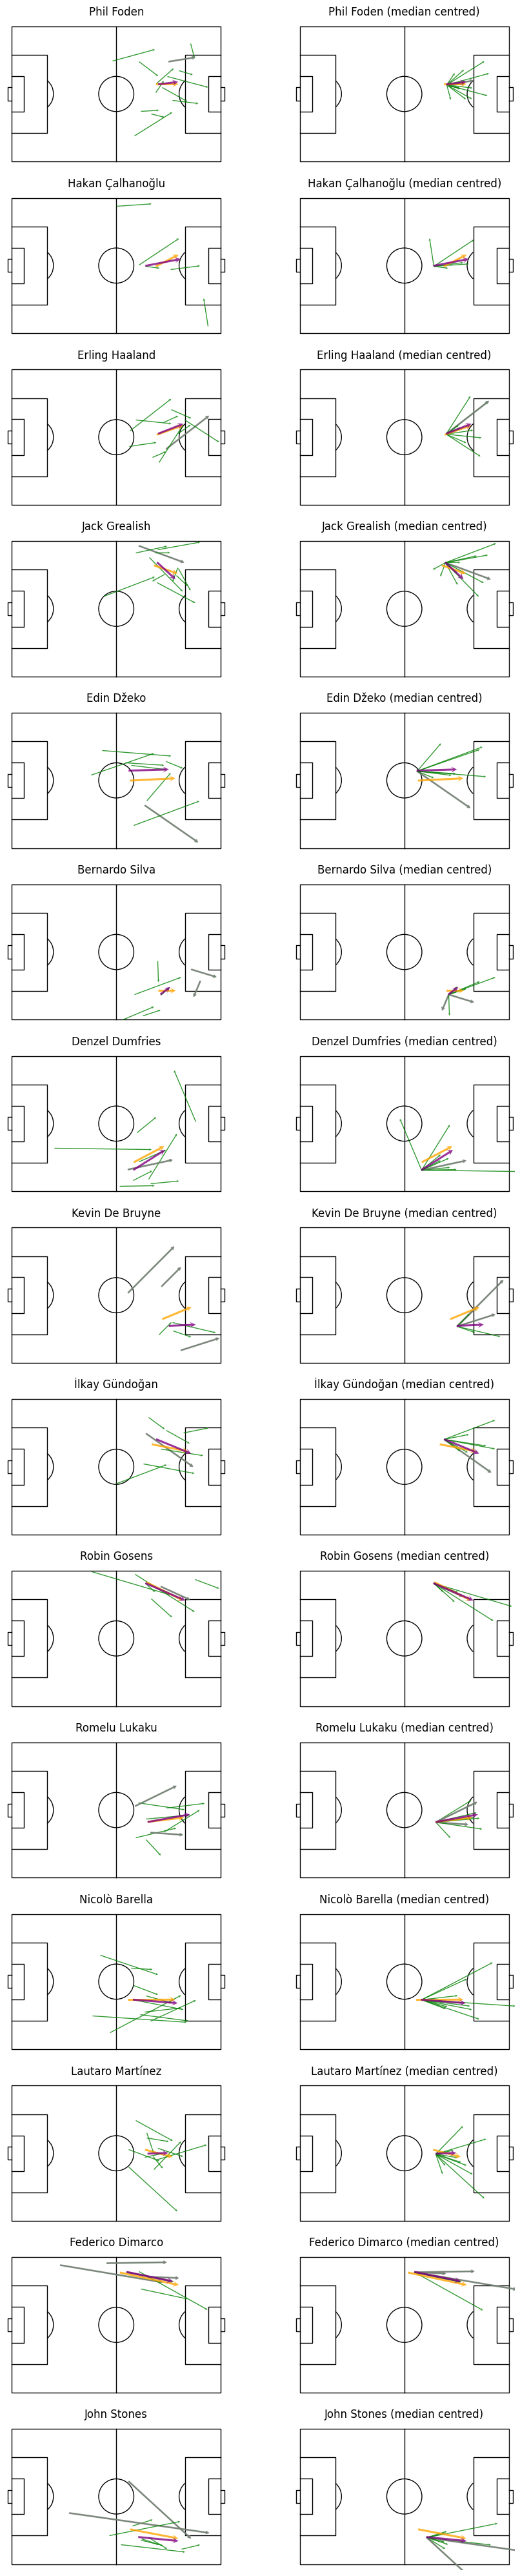

In [ ]:
n_players = len(player_stats_df.index)
fig, axs = plt.subplots(nrows=n_players, ncols=2, figsize=(10, 40))

axs = axs.flatten()

for i in range(n_players * 2):
    axs[i].axis('off')

for i, player in zip(range(0, 2 * n_players, 2), player_stats_df.index):
    plot_player_subgrid(axs[i], player, '')
    plot_player_subgrid(axs[i+1], player, ' (median centred)', median_centred=True)

plt.tight_layout()
fig.savefig(f"off-ball-runs.png", format='png', dpi=200, facecolor=fig.get_facecolor())